### **Deep Learning**

---

**Image Classification**

**Assignment 1: Fashion MNIST**

**Prof: Prodromos Malakasiotis**

**Author: Andreas Stavrou**

---

**Objective**: *Given an image of a fashion item, build a deep learning model that recognizes the fashion item.*

#### Libraries

In [ ]:
#pip install keras-tuner --upgrade

In [22]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, BatchNormalization, MaxPooling2D, Conv2D, Flatten, Dense, Dropout,Activation,MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support,log_loss,accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

#### Data

Data - I loaded the dataset out from the keras datasets library and did the basic preprocessing of reshaping - normalizing and turning labels to categorical for the 10 classes, this code is taken out of the professor's example on fashion mnist classification problem. 

In [23]:
classes = 10

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = to_categorical(y_train, classes)
Y_test = to_categorical(y_test, classes)

#### Helper Functions

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
#Setting early_stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    min_delta=0.0000001,
    restore_best_weights=True,
)

In [26]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

#### **CNN Models**

In [6]:
# Generating 25 million more images by randomly rotating, scaling and shifting fashion mnist images
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

Addition of normalization layers and a third conv layer. I want to figure out if by adding one more conv layer will improve anything, it's a minor update and worth trying.

In [12]:
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(28, 28, 1))
    
    # Block One
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.3)(x)

    # Block Two
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.3)(x)

    # Block Three
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.3)(x)

    # Head
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    #Final Layer (Output)
    output = layers.Dense(classes, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [13]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='categorical_crossentropy', 
                optimizer = keras.optimizers.Adam(learning_rate=0.001), 
                metrics='accuracy')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496 

-------------------------

In [27]:
# Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=0.1,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [28]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 2)

In [29]:
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(28, 28, 1))
    
    # Block One
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)

    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Block Four
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)

    # Head
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    #Final Layer (Output)
    output = layers.Dense(classes, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [30]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='categorical_crossentropy', 
                optimizer = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), 
                metrics='accuracy')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0     

In [31]:
epochs = 100
batch_size = 128

In [32]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                              shuffle=True, 
                              epochs=epochs, validation_data = (x_val, y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[early_stopping])

Epoch 1/100
  1/421 [..............................] - ETA: 1:05 - loss: 2.7570 - accuracy: 0.0781

/Users/andreas/miniforge3/envs/tensorflowgpu2/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


421/421 [==============================] - 26s 61ms/step - loss: 0.5076 - accuracy: 0.8105 - val_loss: 1.1240 - val_accuracy: 0.6398
Epoch 2/100
421/421 [==============================] - 26s 61ms/step - loss: 0.3491 - accuracy: 0.8705 - val_loss: 0.2767 - val_accuracy: 0.8948
Epoch 3/100
421/421 [==============================] - 25s 60ms/step - loss: 0.3072 - accuracy: 0.8845 - val_loss: 0.2892 - val_accuracy: 0.8945
Epoch 4/100
421/421 [==============================] - 25s 59ms/step - loss: 0.2846 - accuracy: 0.8946 - val_loss: 0.2783 - val_accuracy: 0.8940
Epoch 5/100
421/421 [==============================] - 25s 58ms/step - loss: 0.2656 - accuracy: 0.9024 - val_loss: 0.2293 - val_accuracy: 0.9150
Epoch 6/100
421/421 [==============================] - 25s 58ms/step - loss: 0.2508 - accuracy: 0.9072 - val_loss: 0.2702 - val_accuracy: 0.8997
Epoch 7/100
421/421 [==============================] - 24s 58ms/step - loss: 0.2412 - accuracy: 0.9107 - val_loss: 0.2438 - val_accuracy: 0.91

Confussion matrix

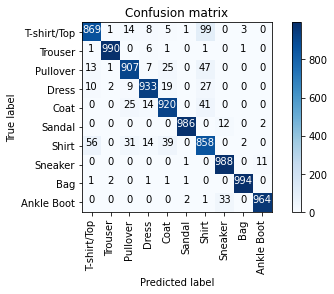

In [33]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

Classification report

In [34]:
classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(classification_report(Y_true, Y_pred_classes, target_names = classes))

              precision    recall  f1-score   support

 T-shirt/Top       0.91      0.87      0.89      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.92      0.91      0.91      1000
       Dress       0.95      0.93      0.94      1000
        Coat       0.91      0.92      0.92      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.80      0.86      0.83      1000
     Sneaker       0.96      0.99      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle Boot       0.99      0.96      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



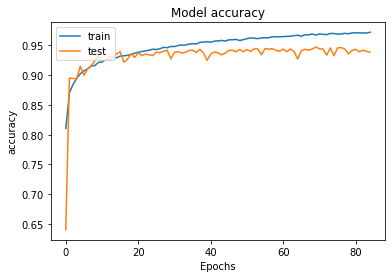

In [38]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

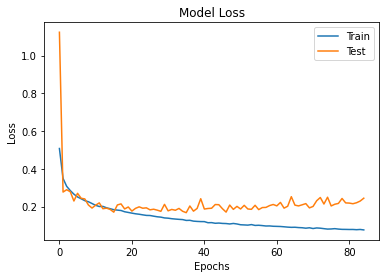

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

In [37]:
score = model.evaluate(X_test, Y_test, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

 10/313 [..............................] - ETA: 5s - loss: 0.1652 - accuracy: 0.9531

/Users/andreas/miniforge3/envs/tensorflowgpu2/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


313/313 [==============================] - 5s 14ms/step - loss: 0.2139 - accuracy: 0.9409
Test loss: 0.21389034390449524
Test accuracy: 0.9409000277519226


In [16]:
score = model.evaluate(X_test, Y_test, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 9ms/step - loss: 0.1794 - accuracy: 0.9380
Test loss: 0.17942845821380615
Test accuracy: 0.9380000233650208


In [17]:
for i in range(len(confusion_mtx)):
    print("Class:",classes[i])
    print("Number of Wrong Prediction:", str(sum(confusion_mtx[i])-confusion_mtx[i][i]), "out of 1000")
    print("Percentage of True Prediction: {:.2f}%".format(confusion_mtx[i][i] / 10))
    print("*********************************************")

Class: T-shirt/Top
Number of Wrong Prediction: 119 out of 1000
Percentage of True Prediction: 88.10%
*********************************************
Class: Trouser
Number of Wrong Prediction: 14 out of 1000
Percentage of True Prediction: 98.60%
*********************************************
Class: Pullover
Number of Wrong Prediction: 93 out of 1000
Percentage of True Prediction: 90.70%
*********************************************
Class: Dress
Number of Wrong Prediction: 83 out of 1000
Percentage of True Prediction: 91.70%
*********************************************
Class: Coat
Number of Wrong Prediction: 48 out of 1000
Percentage of True Prediction: 95.20%
*********************************************
Class: Sandal
Number of Wrong Prediction: 3 out of 1000
Percentage of True Prediction: 99.70%
*********************************************
Class: Shirt
Number of Wrong Prediction: 186 out of 1000
Percentage of True Prediction: 81.40%
*********************************************
Class: S

In [18]:
model.save('best_cnn_arch_model')

2022-05-25 15:24:48.667019: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: best_cnn_arch_model/assets


With the combination of the above architecture and the data augmentation we managed to better the performance of our model on the "Shirt" class which was the weakest at classifing, and from approximately precision 0.73,  recall 0.82, f1-score 0.78 we managed to score precision: 0.82, recall:0.84, f1-score:0.83. 

The **best model** so far managed to achieve **94.09% test accuracy**. 

| Architecture | Test loss | Test accuracy |
| --- | --- | --- |
| 4_block_cnn | 0.1952 | 0.9308 | 
| 5_block_cnn | 0.2138 | **0.9409** | 

#### **CNN Keras Tuner** 

##### Keras tuner - I will try out minor experiments in filters, kernel size, pool size and learning rate. If I had unlimited resources I would tune the model with everything in mind, all possible combinations and filters ranging from 16 to 1024.

In [7]:
def build_cnn_model(hp):
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(28, 28, 1))
    
    # Block One
    x = layers.Conv2D(filters=hp.Int('Filters'+str(1), min_value=16, max_value=32, step=16), 
                               kernel_size=hp.Int('Kernel', min_value=3, max_value=5, step=2),
                               padding='same')(inputs)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Block Two
    x = layers.Conv2D(filters=hp.Int('Filters'+str(2), min_value=16, max_value=32, step=16), 
                               kernel_size=hp.Int('Kernel', min_value=3, max_value=5, step=2),
                               padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = MaxPool2D(pool_size=hp.Int('Pool Size'+str(1), min_value=2, max_value=4, step=2))(x)

    # Block Three
    x = layers.Conv2D(filters=hp.Int('Filters'+str(3), min_value=64, max_value=128, step=16), 
                               kernel_size=hp.Int('Kernel', min_value=3, max_value=5, step=2),
                               padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Block Four
    x = layers.Conv2D(filters=hp.Int('Filters'+str(4), min_value=64, max_value=128, step=16), 
                               kernel_size=hp.Int('Kernel', min_value=3, max_value=5, step=2),
                               padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = MaxPool2D(pool_size=hp.Int('Pool Size'+str(2), min_value=2, max_value=4, step=2))(x)

    # Head
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(hp.Float('Dense_dropout', min_value=0, max_value=0.5))(x)

    #Final Layer (Output)
    output = layers.Dense(classes, activation='softmax')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)

    lr = hp.Float('Learning Rate', min_value=1e-04, max_value=1e-02)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics='accuracy')

    return model

In [8]:
# Instantiate the tuner
tuner = kt.Hyperband(build_cnn_model,
                     objective="val_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=2,
                     directory="kt_dir",
                     project_name="cnn_best_hyper",)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-25 15:48:42.629079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-25 15:48:42.629188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 9
Filters1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 32, 'step': 16, 'sampling': None}
Kernel (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': None}
Filters2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 32, 'step': 16, 'sampling': None}
Pool Size1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 2, 'sampling': None}
Filters3 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 16, 'sampling': None}
Filters4 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 16, 'sampling': None}
Pool Size2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 2, 'sampling': None}
Dense_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
Learning Rate (Float)
{'d

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, Y_train, epochs=20, validation_split=0.1, callbacks=[early_stopping], verbose=1)

Trial 60 Complete [00h 11m 06s]
val_accuracy: 0.9294999837875366

Best val_accuracy So Far: 0.934333324432373
Total elapsed time: 05h 37m 02s
INFO:tensorflow:Oracle triggered exit


Hyperband tuned results

In [11]:
tuner.results_summary()

model=tuner.get_best_models(num_models=1)[0]

model.summary()

model.save('cnn_hyperband_best_model')

Results summary
Results in kt_dir/cnn_best_hyper
Showing 10 best trials
Trial summary
Hyperparameters:
Filters1: 16
Kernel: 5
Filters2: 16
Pool Size1: 2
Filters3: 112
Filters4: 112
Pool Size2: 2
Dense_dropout: 0.19845021247073197
Learning Rate: 0.0017896264229144893
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 0.934333324432373
Trial summary
Hyperparameters:
Filters1: 32
Kernel: 5
Filters2: 32
Pool Size1: 2
Filters3: 96
Filters4: 96
Pool Size2: 2
Dense_dropout: 0.17512782518698278
Learning Rate: 0.0008071078968977086
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9333333373069763
Trial summary
Hyperparameters:
Filters1: 32
Kernel: 3
Filters2: 32
Pool Size1: 2
Filters3: 112
Filters4: 128
Pool Size2: 4
Dense_dropout: 0.20560758029002424
Learning Rate: 0.0022558565102896943
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9331666827201843
Trial summary
Hyperparameters:


2022-05-25 22:05:24.207272: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: cnn_hyperband_best_model/assets


Retrain the model on full data

In [24]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                              shuffle=True, 
                              epochs=epochs, validation_data = (x_val, y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[early_stopping])

/Users/andreas/miniforge3/envs/tensorflowgpu2/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100


2022-05-25 22:07:20.131718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


421/421 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.8900

2022-05-25 22:07:57.583353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


421/421 [==============================] - 39s 93ms/step - loss: 0.3283 - accuracy: 0.8900 - val_loss: 0.0990 - val_accuracy: 0.9707
Epoch 2/100
421/421 [==============================] - 38s 91ms/step - loss: 0.2435 - accuracy: 0.9128 - val_loss: 0.0886 - val_accuracy: 0.9707
Epoch 3/100
421/421 [==============================] - 38s 91ms/step - loss: 0.2207 - accuracy: 0.9193 - val_loss: 0.0886 - val_accuracy: 0.9693
Epoch 4/100
421/421 [==============================] - 39s 92ms/step - loss: 0.2088 - accuracy: 0.9240 - val_loss: 0.0984 - val_accuracy: 0.9633
Epoch 5/100
421/421 [==============================] - 40s 94ms/step - loss: 0.1960 - accuracy: 0.9273 - val_loss: 0.0952 - val_accuracy: 0.9680
Epoch 6/100
421/421 [==============================] - 41s 97ms/step - loss: 0.1879 - accuracy: 0.9290 - val_loss: 0.0945 - val_accuracy: 0.9663
Epoch 7/100
421/421 [==============================] - 42s 100ms/step - loss: 0.1821 - accuracy: 0.9327 - val_loss: 0.1291 - val_accuracy: 0.9

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        6416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 16)        0     

In [29]:
model.save('cnn_hyperband_best_model_rt')

INFO:tensorflow:Assets written to: cnn_hyperband_best_model_rt/assets


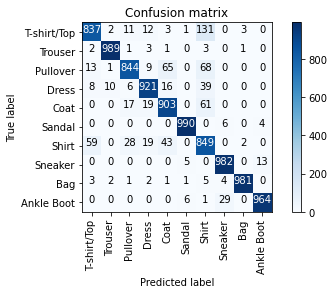

In [30]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

In [31]:
classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(classification_report(Y_true, Y_pred_classes, target_names = classes))

              precision    recall  f1-score   support

 T-shirt/Top       0.91      0.84      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.93      0.84      0.88      1000
       Dress       0.94      0.92      0.93      1000
        Coat       0.88      0.90      0.89      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.73      0.85      0.79      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle Boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [77]:
model = keras.models.load_model('cnn_hyperband_best_model')

In [80]:
score = model.evaluate(X_test, Y_test, verbose = 1)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

  4/313 [..............................] - ETA: 6s - loss: 0.2861 - accuracy: 0.9062 

2022-05-25 23:41:44.126803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 4s 11ms/step - loss: 0.2734 - accuracy: 0.9262
Val loss: 0.27341699600219727
Val accuracy: 0.9262000322341919


#### **Ensemble CNN**

In [9]:
keras.backend.clear_session()

In [14]:
tf.config.run_functions_eagerly(True)

In [16]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 15
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, padding="same",input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Activation("relu"))
    
    model[j].add(Conv2D(32, kernel_size = 3, padding="same"))
    model[j].add(BatchNormalization())
    model[j].add(Activation("relu"))
    model[j].add(MaxPool2D(pool_size=(2,2)))
    
    model[j].add(Conv2D(64, kernel_size = 3, padding='same'))
    model[j].add(BatchNormalization())
    model[j].add(Activation("relu"))

    model[j].add(Conv2D(64, kernel_size = 3, padding="same"))
    model[j].add(BatchNormalization())
    model[j].add(Activation("relu"))
    model[j].add(MaxPool2D(pool_size=(2,2)))
    
    model[j].add(Flatten())
    model[j].add(Dense(256))
    model[j].add(BatchNormalization())
    model[j].add(Activation("relu"))
    model[j].add(Dropout(0.25))
    
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(loss='categorical_crossentropy', 
                optimizer = 'adam', 
                metrics='accuracy')
    model[j].summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_20 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_21 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)       

In [17]:
# TRAIN NETWORKS
history = [0] * nets
epochs = 100
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit(datagen.flow(X_train2,Y_train2, batch_size=128),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//128,  
        validation_data = (X_val2,Y_val2), callbacks=[early_stopping], verbose=1)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

/Users/andreas/miniforge3/envs/tensorflowgpu2/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
2022-05-26 00:29:47.889530: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-26 00:29:47.889668: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
421/421 [==============================] - 28s 64ms/step - loss: 0.6638 - accuracy: 0.7578 - val_loss: 1.2269 - val_accuracy: 0.6067
Epoch 2/100
421/421 [==============================] - 27s 64ms/step - loss: 0.3673 - accuracy: 0.8633 - val_loss: 0.3381 - val_accuracy: 0.8748
Epoch 3/100
421/421 [==============================] - 27s 63ms/step - loss: 0.3151 - accuracy: 0.8817 - val_loss: 0.2225 - val_accuracy: 0.9220
Epoch 4/100
421/421 [==============================] - 27s 63ms/step - loss: 0.2856 - accuracy: 0.8956 - val_loss: 0.3456 - val_accuracy: 0.8727
Epoch 5/100
421/421 [==============================] - 27s 65ms/step - loss: 0.2668 - accuracy: 0.9010 - val_loss: 0.2285 - val_accuracy: 0.9168
Epoch 6/100
421/421 [==============================] - 27s 64ms/step - loss: 0.2556 - accuracy: 0.9045 - val_loss: 0.2274 - val_accuracy: 0.9162
Epoch 7/100
421/421 [==============================] - 27s 63ms/step - loss: 0.2485 - accuracy: 0.9066 - val_loss: 0.2440 - val_ac

In [18]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (X_test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(X_test)
results = np.argmax(results,axis = 1)

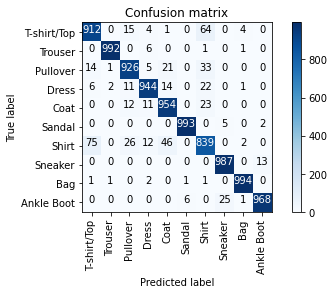

In [19]:
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, results) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

In [20]:
classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(classification_report(Y_true, results, target_names = classes))

              precision    recall  f1-score   support

 T-shirt/Top       0.90      0.91      0.91      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.94      0.93      0.93      1000
       Dress       0.96      0.94      0.95      1000
        Coat       0.92      0.95      0.94      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.85      0.84      0.85      1000
     Sneaker       0.97      0.99      0.98      1000
         Bag       0.99      0.99      0.99      1000
  Ankle Boot       0.98      0.97      0.98      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [21]:
ens_acc = accuracy_score(Y_true, results)

print(ens_acc)

0.9509


| Architecture | Test loss | Test accuracy |
| --- | --- | --- |
| Ensemble_CNNs | 0.1552 | **0.9509** | 

---------------------------------------------------------------------------------------

#### **Transfer Learning**

More ideas: 
* Try transfer learning https://www.tensorflow.org/tutorials/images/transfer_learning 

In [ ]:
fashion_mnist=keras.datasets.fashion_mnist
(train_images,train_label),(test_images,test_label)=fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
print(len(train_images),len(train_label))
print(len(test_images),len(test_label))

60000 60000
10000 10000


In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
from keras.utils import np_utils

pt_x_train = []
pt_y_train = []
pt_x_test = []
pt_y_test = []

tl_x_train = []
tl_y_train = []
tl_x_test = []
tl_y_test = []

m=60000

for i in range(m):
    if train_label[i] < 5:
        pt_x_train.append(train_images[i] / 255)
        pt_y_train.append(train_label[i])
    else:
        tl_x_train.append(train_images[i] / 255)
        tl_y_train.append(train_label[i])

m2 = 10000

for i in range(m2):
    if test_label[i] < 5:
        pt_x_test.append(test_images[i] / 255)
        pt_y_test.append(test_label[i])
    else:
        tl_x_test.append(test_images[i] / 255)
        tl_y_test.append(test_label[i])

pt_x_train = np.asarray(pt_x_train).reshape(-1,28,28,1)
pt_x_test = np.asarray(pt_x_test).reshape(-1,28,28,1)
pt_y_train = np_utils.to_categorical(np.asarray(pt_y_train))
pt_y_test = np_utils.to_categorical(np.asarray(pt_y_test))

tl_x_train = np.asarray(tl_x_train).reshape(-1,28,28,1)
tl_x_test = np.asarray(tl_x_test).reshape(-1,28,28,1)
tl_y_train = np_utils.to_categorical(np.asarray(tl_y_train))
tl_y_test = np_utils.to_categorical(np.asarray(tl_y_test))

                         
print(pt_x_train.shape,pt_y_train.shape)
print(pt_x_test.shape,pt_y_test.shape)

print(tl_x_train.shape,tl_y_train.shape)
print(tl_x_test.shape,tl_y_test.shape)

(30000, 28, 28, 1) (30000, 5)
(5000, 28, 28, 1) (5000, 5)
(30000, 28, 28, 1) (30000, 10)
(5000, 28, 28, 1) (5000, 10)


In [ ]:
from keras.models import Sequential,Model
from keras.layers import Conv2D,Dense,Activation,MaxPool2D,Dropout,Flatten

model = Sequential()
model.add(Conv2D(32,(5,5),input_shape=(28,28,1),activation='relu'))
model.add(Conv2D(16,(5,5),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(8,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(5,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 16)        12816     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 8)           1160      
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
model.fit(pt_x_train,pt_y_train,
         validation_data=(pt_x_test,pt_y_test),
         epochs=10,
         batch_size=100,
         verbose=2,
         shuffle=True)

Epoch 1/10
300/300 - 5s - loss: 0.5155 - accuracy: 0.8033 - val_loss: 0.3352 - val_accuracy: 0.8734 - 5s/epoch - 16ms/step
Epoch 2/10
300/300 - 2s - loss: 0.3156 - accuracy: 0.8855 - val_loss: 0.2701 - val_accuracy: 0.9016 - 2s/epoch - 8ms/step
Epoch 3/10
300/300 - 3s - loss: 0.2696 - accuracy: 0.9025 - val_loss: 0.2441 - val_accuracy: 0.9118 - 3s/epoch - 8ms/step
Epoch 4/10
300/300 - 2s - loss: 0.2447 - accuracy: 0.9130 - val_loss: 0.2189 - val_accuracy: 0.9226 - 2s/epoch - 8ms/step
Epoch 5/10
300/300 - 2s - loss: 0.2332 - accuracy: 0.9154 - val_loss: 0.2155 - val_accuracy: 0.9242 - 2s/epoch - 8ms/step
Epoch 6/10
300/300 - 2s - loss: 0.2157 - accuracy: 0.9227 - val_loss: 0.2252 - val_accuracy: 0.9210 - 2s/epoch - 8ms/step
Epoch 7/10
300/300 - 3s - loss: 0.2071 - accuracy: 0.9244 - val_loss: 0.1978 - val_accuracy: 0.9266 - 3s/epoch - 8ms/step
Epoch 8/10
300/300 - 2s - loss: 0.1987 - accuracy: 0.9279 - val_loss: 0.1920 - val_accuracy: 0.9308 - 2s/epoch - 8ms/step
Epoch 9/10
300/300 - 3s

In [ ]:
for layer in model.layers[:5]:
    layer.trainable = False

In [ ]:
x = model.layers[4].output
x = Dropout(0.5)(x)
x = Dense(32,activation='relu')(x)
x = Dense(16,activation='relu')(x)
predictions = Dense(10,activation='softmax')(x)

In [ ]:
tl_model = Model(model.input,predictions)

In [ ]:
tl_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 16)        12816     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 8)           1160      
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                           

In [ ]:
tl_model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

In [ ]:
tl_model.fit(tl_x_train,tl_y_train,
            validation_data=(tl_x_test,tl_y_test),
            batch_size=100,
            epochs=10,
            verbose=2,
            shuffle=True)

Epoch 1/10
300/300 - 3s - loss: 0.5376 - accuracy: 0.8325 - val_loss: 0.1718 - val_accuracy: 0.9430 - 3s/epoch - 9ms/step
Epoch 2/10
300/300 - 2s - loss: 0.2004 - accuracy: 0.9302 - val_loss: 0.1530 - val_accuracy: 0.9462 - 2s/epoch - 5ms/step
Epoch 3/10
300/300 - 2s - loss: 0.1871 - accuracy: 0.9340 - val_loss: 0.1353 - val_accuracy: 0.9560 - 2s/epoch - 6ms/step
Epoch 4/10
300/300 - 2s - loss: 0.1721 - accuracy: 0.9402 - val_loss: 0.1353 - val_accuracy: 0.9502 - 2s/epoch - 5ms/step
Epoch 5/10
300/300 - 2s - loss: 0.1633 - accuracy: 0.9428 - val_loss: 0.1225 - val_accuracy: 0.9586 - 2s/epoch - 6ms/step
Epoch 6/10
300/300 - 2s - loss: 0.1570 - accuracy: 0.9457 - val_loss: 0.1220 - val_accuracy: 0.9574 - 2s/epoch - 5ms/step
Epoch 7/10
300/300 - 2s - loss: 0.1538 - accuracy: 0.9453 - val_loss: 0.1225 - val_accuracy: 0.9556 - 2s/epoch - 5ms/step
Epoch 8/10
300/300 - 2s - loss: 0.1492 - accuracy: 0.9471 - val_loss: 0.1171 - val_accuracy: 0.9592 - 2s/epoch - 6ms/step
Epoch 9/10
300/300 - 2s 

In [ ]:
score = tl_model.evaluate(tl_x_test, tl_y_test, verbose = 1)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

157/157 [==============================] - 2s 10ms/step - loss: 0.1138 - accuracy: 0.9606
Val loss: 0.11381318420171738
Val accuracy: 0.9606000185012817


The above model scored an impresive 96.01% on validation data. We trained the initial model, then froze the first 5 layers, used the output of the layer number 5 as input and then added some dense layers.

#### **MLP Models**

Reshape data to fit the MLP

In [37]:
X_train = X_train.reshape((60000,784))

X_test = X_test.reshape((10000,784))

##### Small MLP

In [47]:
# Build the model small one
def get_small_mlp():
    inputs = keras.Input(shape=(784,))

    x = layers.Dense(512,activation='relu')(inputs)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    
    return model

In [48]:
keras.backend.clear_session()

model = get_small_mlp()

In [49]:
# Optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999 )

# Compiling the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [51]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [70]:
# train the model!
history_small_mlp = model.fit(X_train,
                        Y_train,
                        epochs = 100,
                        batch_size = 32,
                        validation_split = 0.1,
                        callbacks=[early_stopping])

Epoch 1/100
1688/1688 [==============================] - 19s 11ms/step - loss: 0.1909 - accuracy: 0.9285 - val_loss: 0.3866 - val_accuracy: 0.8933
Epoch 2/100
1688/1688 [==============================] - 18s 11ms/step - loss: 0.1864 - accuracy: 0.9313 - val_loss: 0.3916 - val_accuracy: 0.8892
Epoch 3/100
1688/1688 [==============================] - 19s 11ms/step - loss: 0.1803 - accuracy: 0.9311 - val_loss: 0.3977 - val_accuracy: 0.8945
Epoch 4/100
1688/1688 [==============================] - 18s 10ms/step - loss: 0.1746 - accuracy: 0.9335 - val_loss: 0.4254 - val_accuracy: 0.8897
Epoch 5/100
1688/1688 [==============================] - 19s 11ms/step - loss: 0.1788 - accuracy: 0.9336 - val_loss: 0.3789 - val_accuracy: 0.8930
Epoch 6/100
1688/1688 [==============================] - 18s 11ms/step - loss: 0.1701 - accuracy: 0.9352 - val_loss: 0.4516 - val_accuracy: 0.8887
Epoch 7/100
1688/1688 [==============================] - 18s 11ms/step - loss: 0.1718 - accuracy: 0.9361 - val_loss: 0

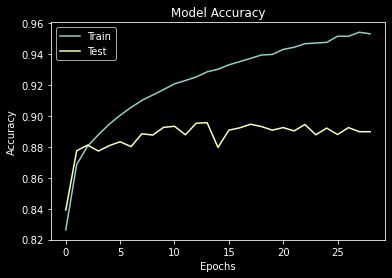

In [59]:
plt.style.use('dark_background')
plt.plot(history_small_mlp.history['accuracy'])
plt.plot(history_small_mlp.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [73]:
score = model.evaluate(X_test, Y_test, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 8ms/step - loss: 0.6280 - accuracy: 0.8906
Test loss: 0.6279959678649902
Test accuracy: 0.8906000256538391


##### Medium MLP

In [60]:
# Build the model small one
def get_medium_mlp():
    inputs = keras.Input(shape=(784,))

    x = layers.Dense(512,activation='relu')(inputs)
    x = layers.Dense(512,activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    
    return model

In [62]:
keras.backend.clear_session()

model = get_medium_mlp()

In [63]:
# Optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999 )

# Compiling the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [64]:
# train the model!
history_med_mlp = model.fit(X_train,
                        Y_train,
                        epochs = 100,
                        batch_size = 32,
                        validation_split = 0.1,
                        callbacks=[early_stopping])

Epoch 1/100
   3/1688 [..............................] - ETA: 44s - loss: 2.2657 - accuracy: 0.1667 

2022-05-25 22:49:25.780036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1688/1688 [==============================] - ETA: 0s - loss: 0.5018 - accuracy: 0.8192

2022-05-25 22:49:43.505749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1688/1688 [==============================] - 19s 11ms/step - loss: 0.5018 - accuracy: 0.8192 - val_loss: 0.3925 - val_accuracy: 0.8507
Epoch 2/100
1688/1688 [==============================] - 18s 11ms/step - loss: 0.3777 - accuracy: 0.8626 - val_loss: 0.3737 - val_accuracy: 0.8610
Epoch 3/100
1688/1688 [==============================] - 18s 11ms/step - loss: 0.3403 - accuracy: 0.8756 - val_loss: 0.3572 - val_accuracy: 0.8688
Epoch 4/100
1688/1688 [==============================] - 18s 11ms/step - loss: 0.3177 - accuracy: 0.8831 - val_loss: 0.3673 - val_accuracy: 0.8720
Epoch 5/100
1688/1688 [==============================] - 18s 11ms/step - loss: 0.3024 - accuracy: 0.8886 - val_loss: 0.3571 - val_accuracy: 0.8748
Epoch 6/100
1688/1688 [==============================] - 18s 11ms/step - loss: 0.2879 - accuracy: 0.8927 - val_loss: 0.3419 - val_accuracy: 0.8813
Epoch 7/100
1688/1688 [==============================] - 18s 11ms/step - loss: 0.2748 - accuracy: 0.8971 - val_loss: 0.3511 - val_

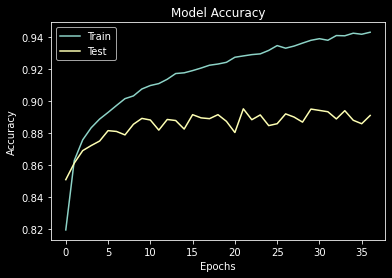

In [68]:
plt.plot(history_med_mlp.history['accuracy'])
plt.plot(history_med_mlp.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [69]:
score = model.evaluate(X_test, Y_test, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 8ms/step - loss: 0.4144 - accuracy: 0.8856
Test loss: 0.41444483399391174
Test accuracy: 0.8856000304222107


##### Large MLP

In [8]:
# Build the model large one
def get_mlp():
    inputs = keras.Input(shape=(784,))

    x = layers.Dense(512,activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512,activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512,activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    
    return model

In [9]:
keras.backend.clear_session()

mlp_model = get_mlp()

In [10]:
# Optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999 )

# Compiling the model
mlp_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
mlp_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0     

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Fitting the model - TRY MORE EPOCHS

In [13]:
# train the model!
history = mlp_model.fit(X_train,
                        Y_train,
                        epochs = 100,
                        batch_size = 32,
                        validation_split = 0.1,
                        callbacks=[early_stopping])

2022-05-23 20:59:35.301727: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-23 20:59:35.304376: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-23 20:59:35.438865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100
1688/1688 [==============================] - ETA: 0s - loss: 0.6328 - accuracy: 0.7699

2022-05-23 20:59:51.768459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1688/1688 [==============================] - 17s 10ms/step - loss: 0.6328 - accuracy: 0.7699 - val_loss: 0.4652 - val_accuracy: 0.8362
Epoch 2/100
1688/1688 [==============================] - 16s 10ms/step - loss: 0.4722 - accuracy: 0.8335 - val_loss: 0.4319 - val_accuracy: 0.8567
Epoch 3/100
1688/1688 [==============================] - 16s 10ms/step - loss: 0.4382 - accuracy: 0.8426 - val_loss: 0.4125 - val_accuracy: 0.8603
Epoch 4/100
1688/1688 [==============================] - 17s 10ms/step - loss: 0.4187 - accuracy: 0.8496 - val_loss: 0.3848 - val_accuracy: 0.8645
Epoch 5/100
1688/1688 [==============================] - 16s 10ms/step - loss: 0.4094 - accuracy: 0.8533 - val_loss: 0.3798 - val_accuracy: 0.8670
Epoch 6/100
1688/1688 [==============================] - 17s 10ms/step - loss: 0.3930 - accuracy: 0.8595 - val_loss: 0.3894 - val_accuracy: 0.8602
Epoch 7/100
1688/1688 [==============================] - 17s 10ms/step - loss: 0.3801 - accuracy: 0.8624 - val_loss: 0.3781 - val_

Plotting loss

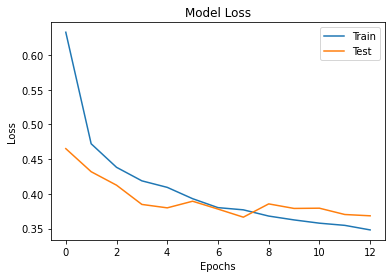

In [14]:
plt.style.use('dark_background')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

Plotting accuracy

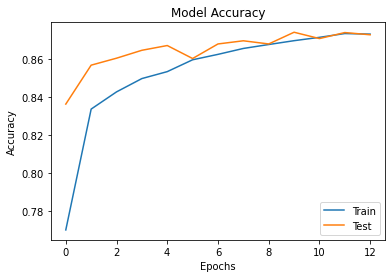

In [15]:
plt.style.use('dark_background')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

Predicting on test data

In [16]:
score = mlp_model.evaluate(X_test, Y_test)

print("Loss: {:.4f}".format(score[0]))
print("Accuracy: {:.4f}".format(score[1]))

313/313 [==============================] - 2s 6ms/step - loss: 0.3807 - accuracy: 0.8710
Loss: 0.3807
Accuracy: 0.8710


Confussion matrix

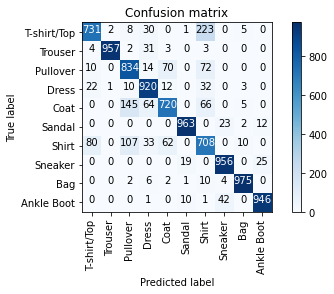

In [21]:
# Predict the values from the validation dataset
Y_pred = mlp_model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

Classification report

In [22]:
print(classification_report(Y_true, Y_pred_classes, target_names = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']))

              precision    recall  f1-score   support

 T-shirt/Top       0.86      0.73      0.79      1000
     Trouser       1.00      0.96      0.98      1000
    Pullover       0.75      0.83      0.79      1000
       Dress       0.84      0.92      0.88      1000
        Coat       0.83      0.72      0.77      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.63      0.71      0.67      1000
     Sneaker       0.93      0.96      0.94      1000
         Bag       0.97      0.97      0.97      1000
  Ankle Boot       0.96      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [23]:
model.save('mlp_model')

2022-05-23 21:04:16.311396: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: mlp_model/assets


| Architecture | Test loss | Test accuracy |
| --- | --- | --- |
| mlp_small | 0.6279 | **0.8906** | 
| mlp_medium | 0.4144 | 0.8856 | 
| mlp_large | **0.3807** | 0.8710 | 

#### **MLP Keras tuner**

In [24]:
def build_model(hp):

    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    
    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 5
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 2, 6)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
                activation="relu")
            )
        
        # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
        model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    # Add output layer.
    model.add(keras.layers.Dense(units=10, activation="softmax"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

In [25]:
# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=20,
                     directory="kt_dir",
                     project_name="mlp_hyperband",)

In [26]:
# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping], verbose=2)

Trial 600 Complete [00h 03m 09s]
val_accuracy: 0.8799166679382324

Best val_accuracy So Far: 0.8974166512489319
Total elapsed time: 10h 31m 34s
INFO:tensorflow:Oracle triggered exit


In [28]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

# Build model
h_model = tuner.hypermodel.build(best_hps)

# Train the hypertuned model
h_model.fit(X_train, y_train, epochs=20, validation_split=0.1, callbacks=[early_stopping], verbose=2)

Epoch 1/20


2022-05-24 07:40:17.307538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2022-05-24 07:40:29.377034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1688/1688 - 13s - loss: 0.6908 - accuracy: 0.7531 - val_loss: 0.4462 - val_accuracy: 0.8392
Epoch 2/20
1688/1688 - 12s - loss: 0.4329 - accuracy: 0.8463 - val_loss: 0.3995 - val_accuracy: 0.8553
Epoch 3/20
1688/1688 - 12s - loss: 0.3811 - accuracy: 0.8625 - val_loss: 0.3751 - val_accuracy: 0.8682
Epoch 4/20
1688/1688 - 12s - loss: 0.3501 - accuracy: 0.8734 - val_loss: 0.3406 - val_accuracy: 0.8765
Epoch 5/20
1688/1688 - 12s - loss: 0.3291 - accuracy: 0.8805 - val_loss: 0.3404 - val_accuracy: 0.8792
Epoch 6/20
1688/1688 - 12s - loss: 0.3113 - accuracy: 0.8872 - val_loss: 0.3379 - val_accuracy: 0.8780
Epoch 7/20
1688/1688 - 12s - loss: 0.2983 - accuracy: 0.8895 - val_loss: 0.3208 - val_accuracy: 0.8823
Epoch 8/20
1688/1688 - 12s - loss: 0.2859 - accuracy: 0.8948 - val_loss: 0.3129 - val_accuracy: 0.8850
Epoch 9/20
1688/1688 - 12s - loss: 0.2739 - accuracy: 0.8992 - val_loss: 0.3343 - val_accuracy: 0.8813
Epoch 10/20
1688/1688 - 12s - loss: 0.2649 - accuracy: 0.9018 - val_loss: 0.3068 - v

In [29]:
h_model.save('tuned_mlp_model')

INFO:tensorflow:Assets written to: tuned_mlp_model/assets


In [74]:
h_model = keras.models.load_model('tuned_mlp_model')

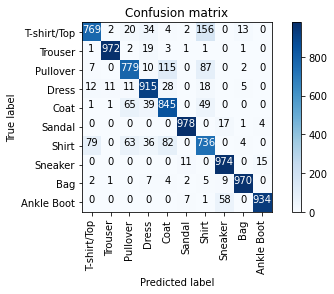

In [13]:
# Predict the values from the validation dataset
Y_pred = h_model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

In [14]:
print(classification_report(Y_true, Y_pred_classes, target_names = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']))

              precision    recall  f1-score   support

 T-shirt/Top       0.88      0.77      0.82      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.83      0.78      0.80      1000
       Dress       0.86      0.92      0.89      1000
        Coat       0.78      0.84      0.81      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.70      0.74      0.72      1000
     Sneaker       0.92      0.97      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle Boot       0.98      0.93      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

